### 1. Project Overview
The Google Play Store hosts millions of Android applications across multiple categories.
Understanding app characteristics, pricing patterns, downloads, and user sentiment is essential for:
- Developers planning new apps
- Marketers optimizing visibility
- Businesses improving retention and user satisfaction
  
This project performs a comprehensive analysis using two datasets:
- apps.csv: App metadata (ratings, installs, size, price, categories, etc.)
- user_reviews.csv: 100 preprocessed user reviews per app (includes sentiment, polarity, subjectivity)

**We aim to answer:**
1. Which categories dominate the store?
2. What influences app rating?
3. Do free vs paid apps differ in installs?
4. What is the sentiment trend in user reviews?
5. Can we build a sentiment classifier using ML?

### 2. Project Objectives
- Clean and preprocess app & review data
- Explore app market structure using EDA
- Convert text reviews to numerical features (TF–IDF)
- Build sentiment classification models
- Compare Naive Bayes vs SVM
- Visualize sentiment distributions
- Extract insights & recommendations

##### Import Libraries & Load Data

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

sns.set_style("darkgrid")


Before doing any analysis, we load our two datasets:
- apps.csv → information about apps  
- user_reviews.csv → user feedback and sentiment  

Loading the data lets us look at the structure and understand what we are working with.

In [138]:
apps = pd.read_csv("apps.csv")
reviews = pd.read_csv("user_reviews.csv")


In [140]:
apps.head()


,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [142]:
reviews.head()


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


##### Data Cleaning (Apps Dataset)
User reviews often contain issues like missing values, symbols, or extra spaces.  
We clean the text to make it readable for the model by:
- removing missing reviews  
- converting text to lowercase  
- removing special characters
- Clean columns: Installs, Size, Price
- removing stopwords (common words like “the”, “is”, “and”)  

Clean text = better model performance.

In [145]:
apps.drop_duplicates(subset="App", inplace=True)

chars = ['+', ',', '$', 'M', 'k']
cols = ["Installs", "Size", "Price"]

for col in cols:
    for c in chars:
        apps[col] = apps[col].astype(str).str.replace(c, '')
    apps[col] = pd.to_numeric(apps[col], errors='coerce')


In [147]:
apps["Rating"].fillna(apps["Rating"].median(), inplace=True)
apps.dropna(subset=["Size", "Installs", "Price"], inplace=True)


##### Exploratory Data Analysis (EDA)
Exploratory Data Analysis helps us understand:
- Number of Apps per Category
- App Rating Distribution
- Size vs. Rating
- Paid vs Free Install Distribution

This step gives us a clear picture of the data.

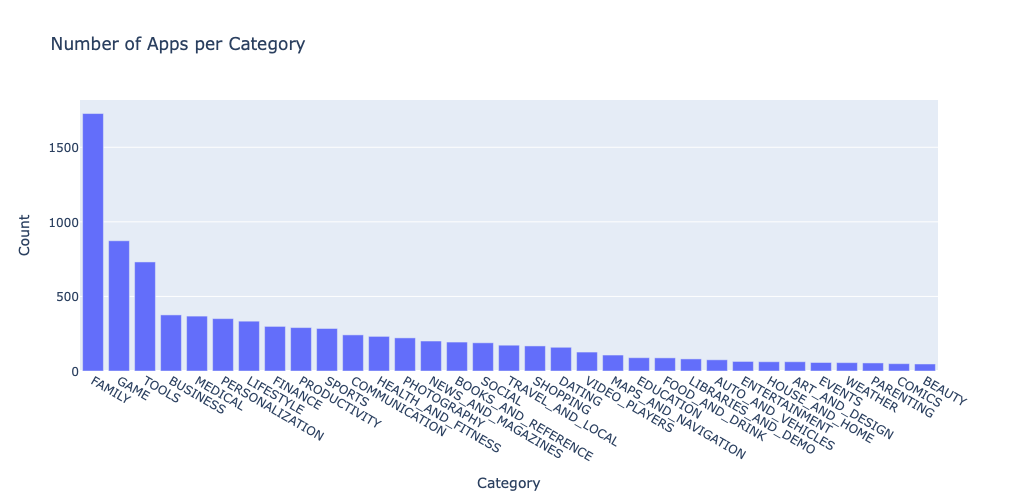

In [232]:
cat_counts = apps["Category"].value_counts()

ffig = go.Figure(data=[go.Bar(
    x=cat_counts.index,
    y=cat_counts.values
)])

fig.update_layout(
    title="Number of Apps per Category", xaxis_title="Category", yaxis_title="Count",width=1000,  
    height=500
)

fig.show()



In [234]:
market_share = (cat_counts / cat_counts.sum()) * 100
market_share.head(10)


Category
FAMILY             20.469639
GAME               10.353416
TOOLS               8.669355
BUSINESS            4.459203
MEDICAL             4.364326
PERSONALIZATION     4.162713
LIFESTYLE           3.961101
FINANCE             3.546015
PRODUCTIVITY        3.451139
SPORTS              3.379981
Name: count, dtype: float64

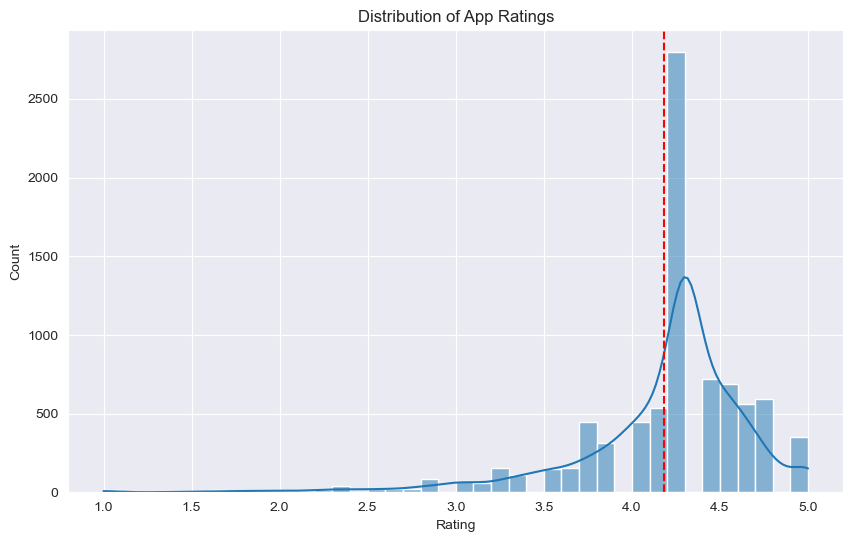

In [236]:
plt.figure(figsize=(10,6))
sns.histplot(apps["Rating"], bins=40, kde=True)
plt.axvline(apps["Rating"].mean(), color='red', linestyle='--')
plt.title("Distribution of App Ratings")
plt.show()


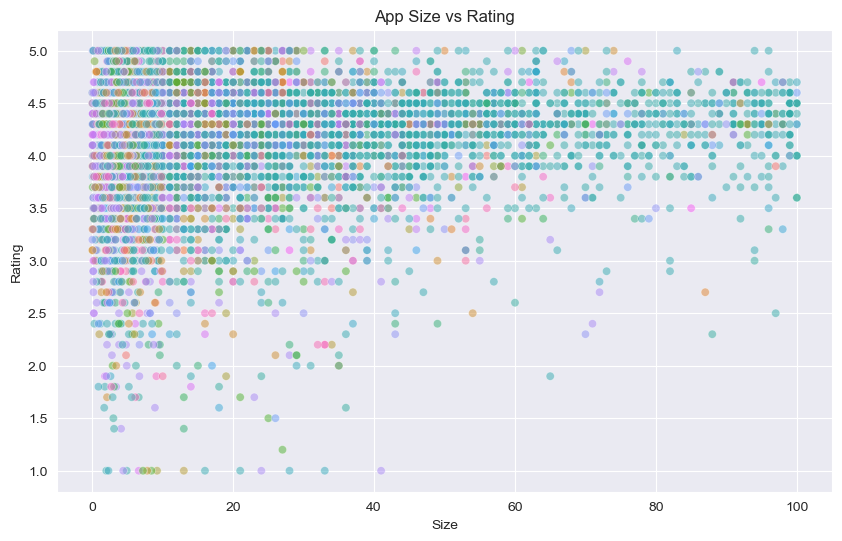

In [237]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=apps, x="Size", y="Rating", hue="Category", alpha=0.5, legend=False)
plt.title("App Size vs Rating")
plt.show()


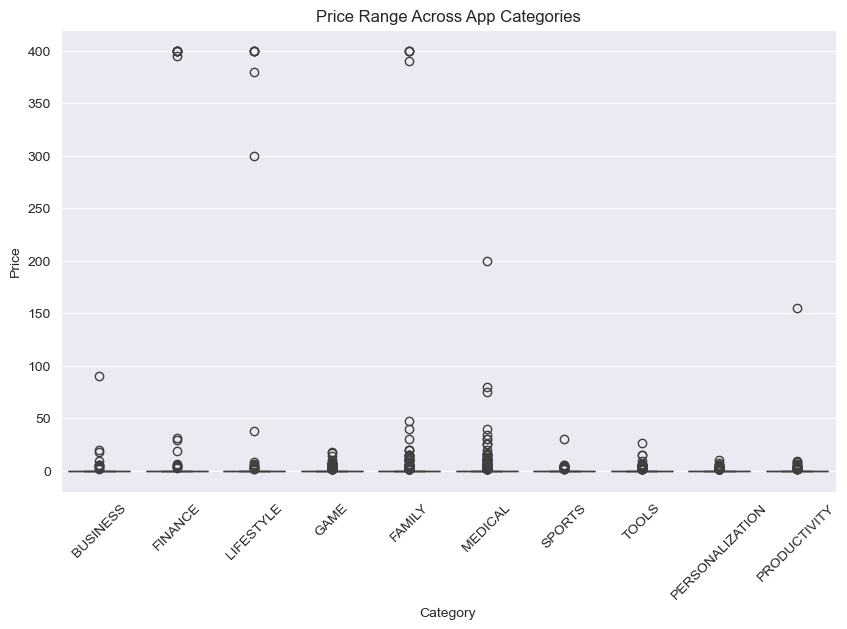

In [239]:
top_cats = apps['Category'].value_counts().nlargest(10).index
subset = apps[apps["Category"].isin(top_cats)]

plt.figure(figsize=(10,6))
sns.boxplot(data=subset, x="Category", y="Price")
plt.xticks(rotation=45)
plt.title("Price Range Across App Categories")
plt.show()


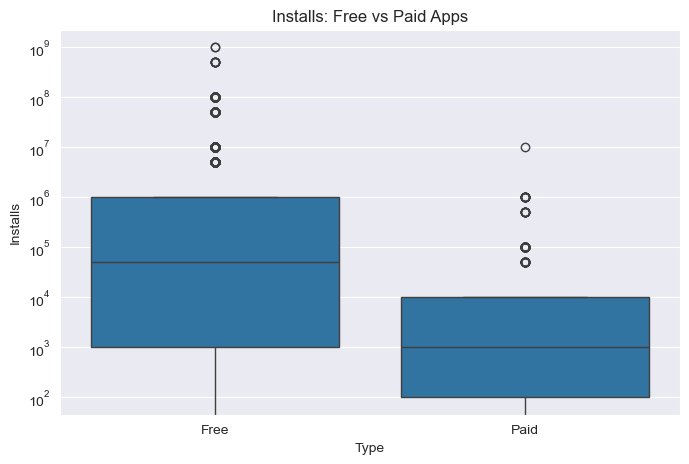

In [240]:
plt.figure(figsize=(8,5))
sns.boxplot(data=apps, x="Type", y="Installs")
plt.yscale("log")
plt.title("Installs: Free vs Paid Apps")
plt.show()


##### Prepare Review Data for Sentiment Analysis
- Remove missing values


In [244]:
reviews = reviews.dropna(subset=['Translated_Review', 'Sentiment'])
reviews.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


##### Convert Text to TF–IDF Features

Machine learning models cannot read text directly. So we convert review text into numerical form using TF–IDF, which gives higher weight to important words.

In [248]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

X = tfidf.fit_transform(reviews['Translated_Review'])
y = reviews['Sentiment']

##### Train/Test Split
We divide the dataset into:
- training data → used to teach the model  
- testing data → used to check how well the model performs  

This prevents the model from memorizing and ensures fairness.

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##### Evaluate the Model Performance
We check:
- accuracy  
- confusion matrix  
- classification report  

This tells us how well each model predicted positive, negative, and neutral reviews.

We train two algorithms:
1. **Naive Bayes** – fast, good for text  
2. **Support Vector Machine (SVM)** – more powerful and often more accurate  

Both models learn patterns from the review text.

##### Model 1 — Naive Bayes

In [254]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

nb_pred = nb.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred))


Naive Bayes Accuracy: 0.7419182473951376
              precision    recall  f1-score   support

    Negative       0.88      0.44      0.59      1653
     Neutral       0.85      0.10      0.18      1049
    Positive       0.72      0.98      0.83      4784

    accuracy                           0.74      7486
   macro avg       0.82      0.51      0.54      7486
weighted avg       0.78      0.74      0.69      7486



##### Model 2 — Support Vector Machine (SVM)

In [257]:
svm = LinearSVC()
svm.fit(X_train, y_train)

svm_pred = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))


SVM Accuracy: 0.9050227090569062
              precision    recall  f1-score   support

    Negative       0.88      0.84      0.85      1653
     Neutral       0.84      0.84      0.84      1049
    Positive       0.93      0.94      0.94      4784

    accuracy                           0.91      7486
   macro avg       0.88      0.87      0.88      7486
weighted avg       0.90      0.91      0.90      7486



##### Compare Model Performance

In [260]:
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))


Naive Bayes Accuracy: 0.7419182473951376
SVM Accuracy: 0.9050227090569062


##### Sentiment Polarity Distribution

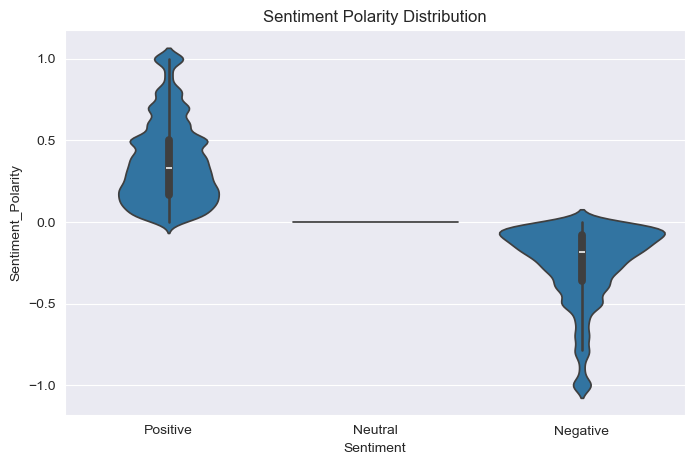

In [263]:
plt.figure(figsize=(8,5))
sns.violinplot(data=reviews, x="Sentiment" , y="Sentiment_Polarity")
plt.title("Sentiment Polarity Distribution")
plt.show()


1. We check how many reviews are:
- Positive  
- Negative  
- Neutral  

This helps us understand whether the dataset is balanced or skewed toward one type of sentiment.

2. Merge App Data with Review Data
To perform meaningful analysis, we combine:
- app features  
- user sentiment  

This lets us understand which categories receive more negative or positive reviews.


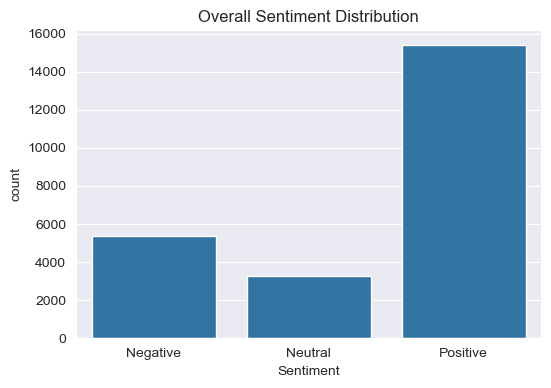

In [193]:
merged = pd.merge(apps, reviews, on='App')  

plt.figure(figsize=(6,4))
sns.countplot(data=merged, x="Sentiment")
plt.title("Overall Sentiment Distribution")
plt.show()


##### Free vs Paid — Sentiment Polarity

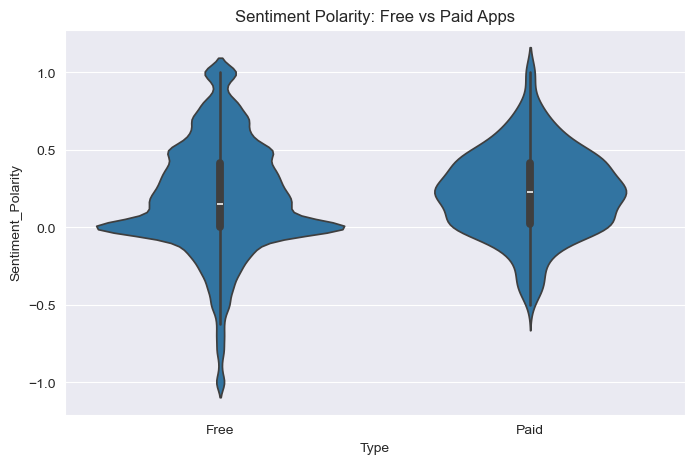

In [199]:
plt.figure(figsize=(8,5))
sns.violinplot(data=merged, x="Type", y="Sentiment_Polarity", inner="box")
plt.title("Sentiment Polarity: Free vs Paid Apps")
plt.show()


### Insights & Recommendations

1. App Market Insights
- The FAMILY and GAME categories dominate the Play Store, holding the largest share of apps.
- Utility-focused categories like TOOLS and BUSINESS also contribute significantly.
- Niche categories (e.g., COMICS, BEAUTY, EVENTS) contain very few apps.

2. App Ratings
- The overall average rating is around 4.17, indicating most apps are well-received.
- Ratings are right-skewed — meaning a majority of apps have high ratings.
- Very few apps fall below the 3.0 rating range.

3. App Pricing
- Most apps are free or priced below $10.
- Medical and Family apps show the highest pricing outliers (up to $400+), but many appear to be “junk apps” or novelty apps.
- After removing overly expensive junk apps, price variation becomes more realistic.

4. Installs: Free vs Paid Apps
- Free apps receive significantly higher installs (shown clearly in log-scaled boxplot).
- Paid apps receive fewer installs, but the gap is not as huge as expected.

5. Sentiment Analysis of Reviews
- Positive reviews dominate, with far fewer neutral or negative reviews.
- Free apps show more negative sentiment polarity outliers, indicating harsher criticism.
- Paid apps exhibit slightly better polarity scores and fewer extreme negative opinions.

6. Model Performance
- Naive Bayes achieved ~74% accuracy.
- SVM (LinearSVC) achieved ~90% accuracy, making it the best-performing model.
- SVM handled neutral sentiment better, which is often the hardest class.

### Recommendations
1. Prioritize User Experience (UX) and App Quality
- Since most apps are rated high, users expect a polished experience.
- Aim to keep app size below 20 MB when possible.

2. Monetization Strategy
- Free apps gain far more installations — ideal for:
     - advertising-based monetization
     - customer acquisition
     - brand awareness
- Paid apps should offer:
     - clear premium value
     - unique features
     - high-quality UI/UX

3. Pricing Strategy
- Avoid high prices; stay under $10 unless your app provides specialized value (e.g., medical tools).
- Remove or avoid “junk app” characteristics—users are sensitive to pricing fairness.

4. Focus on High-Demand Categories
- FAMILY, GAME, TOOLS, and BUSINESS categories show strong market presence.
- Entering small categories may allow easier ranking but limited audience reach.

5. Improve Customer Support for Free Apps
- Free apps receive more negative feedback outliers, so:
     - provide timely updates
     - fix bugs quickly
     - respond to feedback
     - reduce intrusive ads

6. Use Sentiment Analysis Continuously
- Monitor polarity scores to understand user frustration vs satisfaction.
- Use sentiment insights to prioritize features and bug fixes.

7. Choose the Right ML Model
- For sentiment analysis tasks, prefer SVM over Naive Bayes for:
    - better accuracy
    - stronger classification of tricky neutral statements
    - better generalization


### Conclusion
This project reveals that the Google Play Store is dominated by Family and Game apps, with most applications receiving positive ratings. Free apps remain significantly more popular in terms of downloads but attract harsher criticism. App size, pricing, and category strongly influence user engagement. Sentiment analysis shows that user reviews are mostly positive, with paid apps receiving fewer extreme negative comments.
Machine learning models further strengthen insights, with SVM achieving superior accuracy in classifying sentiment.
These findings can guide developers in designing better apps, selecting the right category, setting appropriate prices, and improving user satisfaction.